In [1]:
# Importing necessary libraries 

from pyspark.ml import Pipeline # pipeline to transform data
from pyspark.sql import SparkSession # to initiate spark
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.ml.feature import VectorIndexer # convert label to index
from pyspark.sql.functions import concat_ws, col , countDistinct # to concatinate cols
from pyspark.ml.classification import LogisticRegression # ml model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator # for hyperparameter tuning
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics # # performance metrics
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType

In [2]:
from sklearn.metrics import accuracy_score

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

### PART 1 Select Data and Convert Genres to Index

In [4]:
# create index for label_genre
movie_df = pd.read_csv("./Resources/movie_machine_learning.csv")
label_df = movie_df.value_counts('label_genre').to_frame('count').reset_index(drop=False).reset_index(drop=False)
label_df['index'] = label_df['index'] + 1
label_df_s = label_df[['index' , 'label_genre' ]]

# select datas for this machine learning, combined into one text
movie_df = pd.merge( movie_df , label_df_s , on = 'label_genre')
movie_df_s = movie_df[[ 'title', 'overview', 'tagline', 'plot' ]]

movie_df_s

,title,overview,tagline,plot
0,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,Fear can hold you prisoner. Hope can set you f...,"Over the course of several years, two convicts..."
1,The Dark Knight,Batman raises the stakes in his war on crime. ...,Welcome to a world without rules.,When the menace known as the Joker wreaks havo...
2,Pulp Fiction,"A burger-loving hit man, his philosophical par...",Just because you are a character doesn't mean ...,"The lives of two mob hitmen, a boxer, a gangst..."
3,City of God,"In the slums of Rio, two kids' paths diverge a...","If you run, the beast catches you; if you stay...","In the slums of Rio, two kids' paths diverge a..."
4,The Silence of the Lambs,Clarice Starling is a top student at the FBI's...,To enter the mind of a killer she must challen...,A young F.B.I. cadet must receive the help of ...
...,...,...,...,...
9990,Bubble Boy,Jimmy is a young man who was born without an i...,Life is an adventure. Don't blow it.,Bubble Boy's been in a bubble all his life due...
9991,Noah,A man who suffers visions of an apocalyptic de...,The end of the world is just the beginning.,Noah is chosen by God to undertake a momentous...
9992,OSS 117: From Africa with Love,"1981. Hubert Bonisseur de la Bath, aka OSS 117...",NaN,The third entry in secret agent OSS 117's paro...
9993,Amelia,A look at the life of legendary American pilot...,NaN,A look at the life of legendary American pilot...


In [5]:

# combine to one text srting
movie_df['text'] = ""
for i in range(len(movie_df_s)):
    temp_list = movie_df_s.loc[i,:]
    
    # remove all non alphabatic content
    temp_text = " ".join( [ re.sub( "[^A-Za-z]" , " " , str(j)) for j in temp_list] )
    
    # lower case
    temp_text = temp_text.lower()
    
    movie_df.loc[ i , 'text'] = temp_text

# due to the punctual, pandas dataframe has troble to ready by spark, save as csv then load to spark
movie_df = movie_df[[ 'index' , 'imdb_id', 'text' ]]
movie_df.to_csv("./Resources/movie_ml_label_genre.csv" , index=False )

label_df

,index,label_genre,count
0,1,Romance,1115
1,2,Crime,1085
2,3,Comedy,1034
3,4,Mystery,867
4,5,Animation,855
5,6,Science Fiction,747
6,7,Drama,676
7,8,Horror,617
8,9,Fantasy,577
9,10,History,345


### PART 2 Machine Learning - Multi-Class Version - Collapse to One Label - Use Text Description of a Movie to Predict the Key Genre

Code Reference: https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark

In [6]:
# create a new spark session
spark = SparkSession.builder.master("local[*]")\
                            .appName("news classfier")\
                            .getOrCreate()

# load dataset
df = spark.read.csv("./Resources/movie_ml_label_genre.csv", inferSchema=True, header=True , quote = "\"" , escape =  "\"" )

# show top 20 rows
df.show()

+-----+---------+--------------------+
|index|  imdb_id|                text|
+-----+---------+--------------------+
|    2|tt0111161|the shawshank red...|
|    2|tt0468569|the dark knight b...|
|    2|tt0110912|pulp fiction a bu...|
|    2|tt0317248|city of god in th...|
|    2|tt0102926|the silence of th...|
|    2|tt0110413|l on  the profess...|
|    2|tt0054407|le trou four pris...|
|    2|tt0101985|a brighter summer...|
|    2|tt0114814|the usual suspect...|
|    2|tt5580266|the hate u give r...|
|    2|tt7286456|joker during the ...|
|    2|tt0407887|the departed to t...|
|    2|tt0075314|taxi driver a men...|
|    2|tt0036775|double indemnity ...|
|    2|tt0105236|reservoir dogs a ...|
|    2|tt0106469|bound by honor ba...|
|    2|tt0053291|some like it hot ...|
|    2|tt1392214|prisoners keller ...|
|    2|tt0054248|rocco and his bro...|
|    2|tt3228774|cruella in     s ...|
+-----+---------+--------------------+
only showing top 20 rows



In [7]:
# Renaming 'Class Index' col to 'label'
df = df.withColumnRenamed('index', 'label')

# gourpby to check the label
temp_df = df.groupBy( 'label').count()
temp_df .show()

+-----+-----+
|label|count|
+-----+-----+
|   12|  333|
|    1| 1115|
|   13|  303|
|   16|  259|
|    6|  747|
|    3| 1034|
|    5|  855|
|   15|  291|
|    9|  577|
|    8|  617|
|    7|  676|
|   10|  345|
|   11|  345|
|    2| 1085|
|   17|  246|
|    4|  867|
|   14|  300|
+-----+-----+



In [8]:
# select label and feature
df = df.select('label', 'imdb_id', 'text')
df.show(10)

+-----+---------+--------------------+
|label|  imdb_id|                text|
+-----+---------+--------------------+
|    2|tt0111161|the shawshank red...|
|    2|tt0468569|the dark knight b...|
|    2|tt0110912|pulp fiction a bu...|
|    2|tt0317248|city of god in th...|
|    2|tt0102926|the silence of th...|
|    2|tt0110413|l on  the profess...|
|    2|tt0054407|le trou four pris...|
|    2|tt0101985|a brighter summer...|
|    2|tt0114814|the usual suspect...|
|    2|tt5580266|the hate u give r...|
+-----+---------+--------------------+
only showing top 10 rows



In [9]:
# convert sentences to list of words
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

df = tokenizer.transform(df)
df.select(['label','text', 'words']).show(5)

+-----+--------------------+--------------------+
|label|                text|               words|
+-----+--------------------+--------------------+
|    2|the shawshank red...|[the, shawshank, ...|
|    2|the dark knight b...|[the, dark, knigh...|
|    2|pulp fiction a bu...|[pulp, fiction, a...|
|    2|city of god in th...|[city, of, god, i...|
|    2|the silence of th...|[the, silence, of...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [10]:
# A feature transformer that filters out stop words from input. 
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

df = stopwords_remover.transform(df)

df.select(['label','text', 'words', 'filtered']).show(5)

+-----+--------------------+--------------------+--------------------+
|label|                text|               words|            filtered|
+-----+--------------------+--------------------+--------------------+
|    2|the shawshank red...|[the, shawshank, ...|[shawshank, redem...|
|    2|the dark knight b...|[the, dark, knigh...|[dark, knight, ba...|
|    2|pulp fiction a bu...|[pulp, fiction, a...|[pulp, fiction, b...|
|    2|city of god in th...|[city, of, god, i...|[city, god, slums...|
|    2|the silence of th...|[the, silence, of...|[silence, lambs, ...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [11]:
# Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="filtered", outputCol="raw_features", numFeatures=10000)
featurized_data = hashing_tf.transform(df)

# TF-IDF vectorization of articles
idf = IDF(inputCol="raw_features", outputCol="features")
idf_vectorizer = idf.fit(featurized_data)
rescaled_data = idf_vectorizer.transform(featurized_data)

rescaled_data.select("label",'Text', 'words', 'filtered', "features").show()

+-----+--------------------+--------------------+--------------------+--------------------+
|label|                Text|               words|            filtered|            features|
+-----+--------------------+--------------------+--------------------+--------------------+
|    2|the shawshank red...|[the, shawshank, ...|[shawshank, redem...|(10000,[52,585,79...|
|    2|the dark knight b...|[the, dark, knigh...|[dark, knight, ba...|(10000,[495,579,6...|
|    2|pulp fiction a bu...|[pulp, fiction, a...|[pulp, fiction, b...|(10000,[116,160,4...|
|    2|city of god in th...|[city, of, god, i...|[city, god, slums...|(10000,[234,266,4...|
|    2|the silence of th...|[the, silence, of...|[silence, lambs, ...|(10000,[165,237,2...|
|    2|l on  the profess...|[l, on, the, prof...|[l, professional,...|(10000,[157,360,4...|
|    2|le trou four pris...|[le, trou, four, ...|[le, trou, four, ...|(10000,[213,326,4...|
|    2|a brighter summer...|[a, brighter, sum...|[brighter, summer...|(10000,[15

In [12]:
# Split Train/Test data
(train, test) = rescaled_data.randomSplit([0.8 , 0.2], seed = 202)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7954
Test Dataset Count: 2041


In [13]:
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

lrModel = lr.fit(train)
predictions = lrModel.transform(test)

In [14]:
# predictions.show()
predictions.select( "imdb_id", "Text", 'probability','prediction', 'label').show()

+---------+--------------------+--------------------+----------+-----+
|  imdb_id|                Text|         probability|prediction|label|
+---------+--------------------+--------------------+----------+-----+
|tt0016332|seven chances str...|[3.84512027177039...|       1.0|    1|
|tt0022958|grand hotel guest...|[3.41526233711686...|       3.0|    1|
|tt0031725|ninotchka a stern...|[3.07564056937368...|      13.0|    1|
|tt0032599|his girl friday w...|[2.01644521545172...|       7.0|    1|
|tt0033804|the lady eve it s...|[2.66588376462300...|       1.0|    1|
|tt0034583|casablanca in cas...|[3.84054501682187...|       4.0|    1|
|tt0037558|brief encounter r...|[2.97976692726575...|       1.0|    1|
|tt0046345|summer with monik...|[3.36936738959307...|       1.0|    1|
|tt0048356|marty marty  a bu...|[3.00703629480749...|       1.0|    1|
|tt0049866|toto  peppino  an...|[2.74161111286411...|       3.0|    1|
|tt0053604|the apartment bud...|[2.95857641399855...|       1.0|    1|
|tt005

In [15]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
accuracy_rate = evaluator.evaluate(predictions)
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))

Test-set Accuracy is :  0.3792171568161955


### Compare Machine Learning with Educated Random Guess

In [16]:
# random number generater with probablity
label_df['probability'] = label_df['count']/sum(label_df['count'])
label_df

,index,label_genre,count,probability
0,1,Romance,1115,0.111556
1,2,Crime,1085,0.108554
2,3,Comedy,1034,0.103452
3,4,Mystery,867,0.086743
4,5,Animation,855,0.085543
5,6,Science Fiction,747,0.074737
6,7,Drama,676,0.067634
7,8,Horror,617,0.061731
8,9,Fantasy,577,0.057729
9,10,History,345,0.034517


In [17]:
# assign a random label for movie, base on probability
movie_df['radom_guess'] = [ np.random.choice(np.arange(1, len(label_df)+1), p=list(label_df['probability']) ) for rown in range(len(movie_df)) ]
movie_df

,index,imdb_id,text,radom_guess
0,2,tt0111161,the shawshank redemption framed in the s f...,12
1,2,tt0468569,the dark knight batman raises the stakes in hi...,9
2,2,tt0110912,pulp fiction a burger loving hit man his phil...,1
3,2,tt0317248,city of god in the slums of rio two kids pat...,15
4,2,tt0102926,the silence of the lambs clarice starling is a...,3
...,...,...,...,...
9990,14,tt0258470,bubble boy jimmy is a young man who was born w...,8
9991,14,tt1959490,noah a man who suffers visions of an apocalypt...,1
9992,14,tt7972012,oss from africa with love hubert bo...,1
9993,14,tt1129445,amelia a look at the life of legendary america...,1


In [18]:
# repeat this random guess for n times and collect the result

repeat_n = 100

random_accuracy = []

for i in range(repeat_n):
    movie_df['radom_guess'] = [ np.random.choice(np.arange(1, len(label_df)+1), p=list(label_df['probability']) ) for rown in range(len(movie_df)) ]
    random_accuracy.append( accuracy_score( list(movie_df['index']) , list(movie_df['radom_guess']) ) )
    
    if i % 20 == 0 :
        print(f'{i} / {repeat_n}')

0 / 100
20 / 100
40 / 100
60 / 100
80 / 100


Throw a Dice 1/17 is: 0.058823529411764705
Best Accuracy of Educated Random Guess (100 Repeats) is: 0.0817408704352176
Average Accuracy of Educated Random Guess (100 Repeats) is: 0.07426613306653329
Machine Learning Test-set Accuracy is :  0.3792171568161955
Machine Learning is 4.64 times better than guess


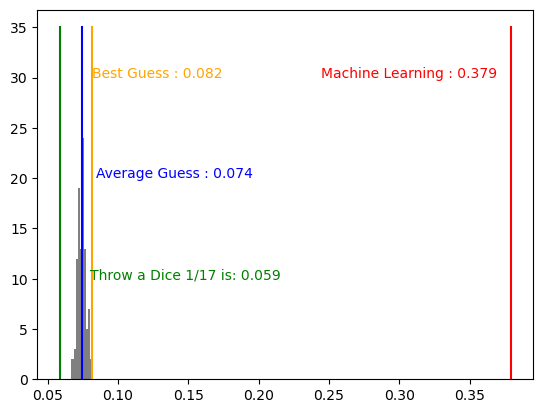

In [19]:
# histogram for accuracy in educated random guess
n_bins = 10

# set the number of bins with the *bins* keyword argument.
plt.hist(random_accuracy, bins=n_bins , color="grey" )
plt.plot([accuracy_rate,accuracy_rate], [0, 35], color = 'red')

# average accuracy in guess
temp_avg = sum(random_accuracy)/len(random_accuracy)

plt.plot([max(random_accuracy),max(random_accuracy)], [0, 35], color = 'orange')
plt.plot([temp_avg,temp_avg], [0, 35], color = 'blue')
plt.plot([1/len(label_df),1/len(label_df)], [0, 35], color = 'green')

# text label
plt.text( 0.08 ,10, f'Throw a Dice 1/{len(label_df)} is: { round( 1/len(label_df) , 3) }', ha='left', wrap=True , color = 'green')
plt.text(max(random_accuracy),30, f'Best Guess : {round(max(random_accuracy),3)}', ha='left', wrap=True, color = 'orange')
plt.text(temp_avg+0.01, 20, f'Average Guess : {round(temp_avg,3)}', ha='left', wrap=True , color = 'blue' )
plt.text(accuracy_rate-0.01, 30, f'Machine Learning : {round(evaluator.evaluate(predictions),3)}', ha='right', wrap=True , color ='red' )

print(f'Throw a Dice 1/{len(label_df)} is: { 1/len(label_df) }')
print(f'Best Accuracy of Educated Random Guess ({repeat_n} Repeats) is: {max(random_accuracy) }')
print(f'Average Accuracy of Educated Random Guess ({repeat_n} Repeats) is: {temp_avg}')
print("Machine Learning Test-set Accuracy is : ", evaluator.evaluate(predictions))
print(f"Machine Learning is { round(evaluator.evaluate(predictions) / max(random_accuracy), 2) } times better than guess")

### PART 3 Machine Learning - Multi-Label Version - Predict Multiple Possible Labels - Use Text Description of a Movie to Predict the Multiple Genres

Code Reference: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

In [21]:
# load data
movie_df = pd.read_csv("./Resources/movie_machine_learning.csv")

# select datas for this machine learning, combined into one text
movie_df_s = movie_df[[ 'title', 'overview', 'tagline', 'plot' ]]
movie_df['text'] = ""
for i in range(len(movie_df_s)):
    temp_list = movie_df_s.loc[i,:]
    
    # remove all non alphabatic content
    temp_text = " ".join( [ re.sub( "[^A-Za-z]" , " " , str(j)) for j in temp_list] )
    
    # lower case
    temp_text = temp_text.lower()
    
    movie_df.loc[ i , 'text'] = temp_text

# convert all_genres to list, as predict target
movie_generes = []
for i in range(len(movie_df)) :
    
    temp_generes = []
    try :
        temp_generes = movie_df.loc[ i, 'all_genres'].split(", ")
    except :
        pass
    movie_generes.append(temp_generes)
    
# select columns for this machine learning
movie_df = movie_df[['imdb_id', 'title', 'overview' , 'text' ]]

print(movie_generes[:5])
movie_df.head()

[['Drama', 'Crime'], ['Drama', 'History', 'War'], ['Animation', 'Action', 'Adventure'], ['Animation', 'Family', 'Fantasy'], ['Comedy', 'Thriller', 'Drama']]


,imdb_id,title,overview,text
0,tt0111161,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,the shawshank redemption framed in the s f...
1,tt0108052,Schindler's List,The true story of how businessman Oskar Schind...,schindler s list the true story of how busines...
2,tt9362722,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Brooklyn’s fu...",spider man across the spider verse after reun...
3,tt0245429,Spirited Away,"A young girl, Chihiro, becomes trapped in a st...",spirited away a young girl chihiro becomes t...
4,tt6751668,Parasite,"All unemployed, Ki-taek's family takes peculia...",parasite all unemployed ki taek s family take...


In [22]:
# remove stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movie_df['text'] = movie_df['text'].apply(lambda x: remove_stopwords(x))

In [23]:
# convert multi labels to target variable
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movie_generes)
y = multilabel_binarizer.transform(movie_generes)

In [24]:
# check labels in selection. avoide error in reading list format
label_ls = multilabel_binarizer.classes_
label_ls = [i for i in label_ls]
label_ls

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [25]:
# sample target in y
y[0]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movie_df['text'], y, test_size=0.2, random_state=9)

In [27]:
# Extracting Features from Text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [28]:
# use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [29]:
# sample result
multilabel_binarizer.inverse_transform(y_pred)[0]

('Drama', 'Romance')

In [30]:
# evaluate performance
performance_score = f1_score(yval, y_pred, average="micro")
print("Test-set Performance Score is : ", performance_score)

Test-set Performance Score is :  0.5003933910306845


In [31]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

# threshold value lest then threshold is 0, > is 1
threshold_value = 0.35

# pick the predict result, use threshold value and max probability if threshold value doesn't get any result
y_pred_new = []

for i in range(len( y_pred_prob )) :
    temp_pred = y_pred_prob[i]
    temp_max = max(temp_pred)
    one_pred = ( temp_pred > threshold_value ) | (temp_pred == temp_max ).astype(int)
    y_pred_new.append(one_pred)

accuracy_predict = f1_score(yval, y_pred_new, average="micro")
print(f"Machine Learning Test-set with Threshold {threshold_value} Accuracy is : {accuracy_predict}" )

Machine Learning Test-set with Threshold 0.35 Accuracy is : 0.6170123611984076


In [32]:
# distribution of prediction genres
y_pred_label = []
for i in range(len(y_pred_new)) :
    temp_ls = y_pred_new[i]
    for j in range(len(temp_ls)) :
        if bool(temp_ls[j]) :
            y_pred_label.append( label_ls[j] )

predict_df = pd.DataFrame( { "label" : y_pred_label } )
predict_df = predict_df.value_counts('label').to_frame('predict_count').reset_index(drop=False)

predict_df['predict_probability'] = predict_df['predict_count'] / sum(predict_df['predict_count'] )
predict_df

,label,predict_count,predict_probability
0,Drama,1392,0.319853
1,Comedy,915,0.210248
2,Thriller,477,0.109605
3,Action,393,0.090303
4,Romance,248,0.056985
5,Crime,198,0.045496
6,Adventure,193,0.044347
7,Horror,107,0.024586
8,Family,102,0.023438
9,Science Fiction,101,0.023208


In [33]:
# distribution of actual genres
y_actual_label = []

for i in range(len(yval)) : # y validation
    temp_ls = yval[i]
    for j in range(len(temp_ls)) :
        if bool(temp_ls[j]) :
            y_actual_label.append( label_ls[j] )

actual_df = pd.DataFrame( { "label" : y_actual_label } )
actual_df = actual_df.value_counts('label').to_frame('act_count').reset_index(drop=False)

actual_df['act_probability'] = actual_df['act_count'] / sum(actual_df['act_count'] )

# compare 
compare_df = pd.merge( actual_df , predict_df, on = 'label' )
compare_df['compare'] = compare_df['predict_probability'] / compare_df['act_probability']
compare_df = compare_df.sort_values('compare',ascending=False)

compare_df

,label,act_count,act_probability,predict_count,predict_probability,compare
0,Drama,944,0.181748,1392,0.319853,1.759869
1,Comedy,755,0.145360,915,0.210248,1.446396
2,Thriller,498,0.095880,477,0.109605,1.143147
3,Action,452,0.087023,393,0.090303,1.037689
4,Romance,366,0.070466,248,0.056985,0.808693
6,Crime,330,0.063535,198,0.045496,0.716085
5,Adventure,331,0.063727,193,0.044347,0.695893
10,Science Fiction,204,0.039276,101,0.023208,0.590887
8,Family,217,0.041779,102,0.023438,0.560988
7,Horror,233,0.044859,107,0.024586,0.548076


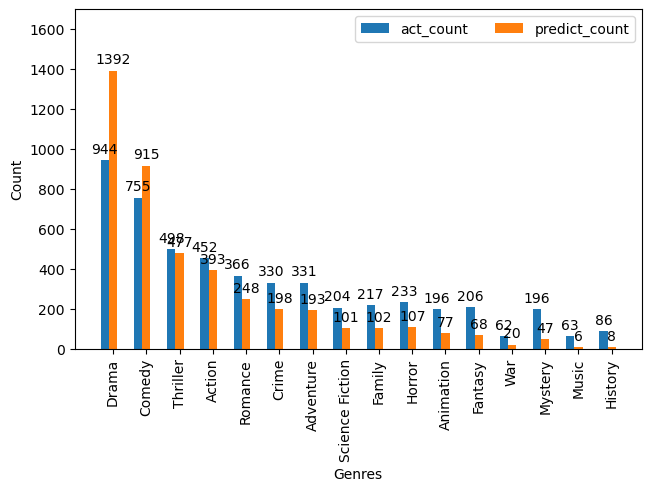

In [34]:
# plot for compare_df
count_type = list(compare_df['label'])
genre_counts = { 'act_count' : list(compare_df['act_count']) , 'predict_count' : list(compare_df['predict_count'])  }

x = np.arange(len(count_type))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in genre_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Genres')
ax.set_xticks(x + width, count_type, rotation = 90)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 1700)

plt.show()

In [35]:
# print some sample

def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict_proba(q_vec)
    max_pred = max(q_pred)
    one_pred = ( q_pred > threshold_value ).astype(int)
    return multilabel_binarizer.inverse_transform(one_pred)

for i in range(10,20): 
    k = xval.sample(1).index[0] 
    print("Movie Title: ", movie_df['title'][k], '\nMovie Description: ' , movie_df['overview'][k] ,"\nPredicted Genre: ", infer_tags(xval[k])), print("Actual Genre: ",movie_generes[k], "\n")

Movie Title:  Wings of Desire 
Movie Description:  Two angels, Damiel and Cassiel, glide through the streets of Berlin, observing the bustling population, providing invisible rays of hope to the distressed but never interacting with them. When Damiel falls in love with lonely trapeze artist Marion, the angel longs to experience life in the physical world, and finds -- with some words of wisdom from actor Peter Falk -- that it might be possible for him to take human form. 
Predicted Genre:  [('Drama', 'Romance')]
Actual Genre:  ['Drama', 'Fantasy', 'Romance'] 

Movie Title:  Saw 
Movie Description:  David, an orderly at a hospital, tells his horrific story of being kidnapped and forced to play a vile game of survival. 
Predicted Genre:  [('Drama', 'Thriller')]
Actual Genre:  ['Crime', 'Horror', 'Thriller'] 

Movie Title:  The Forgotten 
Movie Description:  Telly Paretta is a grieving mother struggling to cope with the loss of her 8-year-old son. She is stunned when her psychiatrist reve

In [36]:
# Implement to book?

text = """
    
    But his arms were so stiff ... they stayed up straight in the air for more than a week, and whenever a fly came and settled on his nose he had to blow it off. And I think – but I am not sure – that that is why he is always called Pooh.
    
    """

print('Book Description: ' , text ,"\nPredicted Genre: ", infer_tags(text) )

Book Description:  
    
    But his arms were so stiff ... they stayed up straight in the air for more than a week, and whenever a fly came and settled on his nose he had to blow it off. And I think – but I am not sure – that that is why he is always called Pooh.
    
     
Predicted Genre:  [('Comedy',)]


In [37]:
# Implement to book?

text = """
    
    Winnie-the-Pooh (also known as Edward Bear, Pooh Bear or simply Pooh) is a fictional anthropomorphic teddy bear created by English author A. A. Milne and English illustrator E. H. Shepard. Winnie-the-Pooh first appeared by name in a children's story commissioned by London's Evening News for Christmas Eve 1925.
    """

print('Book Description: ' , text ,"\nPredicted Genre: ", infer_tags(text) )

Book Description:  
    
    Winnie-the-Pooh (also known as Edward Bear, Pooh Bear or simply Pooh) is a fictional anthropomorphic teddy bear created by English author A. A. Milne and English illustrator E. H. Shepard. Winnie-the-Pooh first appeared by name in a children's story commissioned by London's Evening News for Christmas Eve 1925.
     
Predicted Genre:  [('Drama', 'Family')]
